## Setup

### Model Class

Define a class that can describe the right-hand side of a DDE, 
$$x'(t) = F(x(t), y(t), t) $$

In our case, the right-hand side we want to learn will be
1. $F(x, y, t) = x(1 - y) $
2. $F(x, y, t) = \sin{x}$

The `Model` class defines an object that can act like the function $F$.

### DDE Solver

This is an algorithm to solve a DDE of the following form:
$$\begin{aligned} x'(t) &= F(x(t), x(t - \tau), t) \qquad t \in [0, T] \\
x(t) &= x_0 \qquad \qquad \qquad \qquad \quad  t \in [-\tau, 0] \end{aligned}$$

We find an approximate solution using a forward euler solver for DDEs.

### NDDE class

Here we define the `NDDE_1D` class. This class acts as a wrapper around a `Model` object. Recall that a `Model` object acts like the function $F$ in the following DDE:
$$\begin{aligned} x'(t) &= F(x(t), x(t - \tau), \tau, t) \qquad t \in [0, T] \\
x(t) &= x_0 \qquad \qquad \qquad \qquad \qquad  t \in [-\tau, 0] \end{aligned}$$
The `NDDE_1D` class accepts a `Model`. Its forward method solves the implied DDE on the interval $[0, T]$ and then returns the result.

### Loss

Here, we implement the loss functions that we try to minimize. 

In [1]:
# Python Libraries
import  os;
from    typing              import      List, Dict, Tuple;

# External libraries. 
import  numpy;
import  matplotlib.pyplot       as      plt;
import  matplotlib              as      mpl;
import  seaborn;
import  torch;
from    torch.utils.tensorboard import  SummaryWriter;
from    scipy                   import  interpolate;

# My code
from    Solver  import  RK2                 as DDE_Solver;
from    NDDE    import  NDDE;
from    Train   import  Train;
from    Utils   import  Initialize_Logger, Initialize_MPL, Add_Noise;
from    Loss    import  L1_Cost, L2_Cost, Integral_Loss;

# Set up the TensorBoard SummaryWriter
Base_Dir    : str   = "./Logs";
Counter     : int   = 0;
Log_Dir     : str   = os.path.join(Base_Dir, "Version_" + str(Counter));
while(os.path.isdir(Log_Dir) == True):
    Counter += 1;
    Log_Dir  = os.path.join(Base_Dir, "Version_" + str(Counter));
TB_Writer = SummaryWriter(log_dir = Log_Dir);

# Set up the logger setup.
import  logging;
Initialize_Logger(level = logging.INFO);
LOGGER : logging.Logger = logging.getLogger(__name__);

# Set up cost functions.
l = L1_Cost(Weight = 1.0);
G = L1_Cost(Weight = 0.0);

# Set up plotting. 
Initialize_MPL();

### Generate Target Trajectory

Generate the target trajectory and plot it!

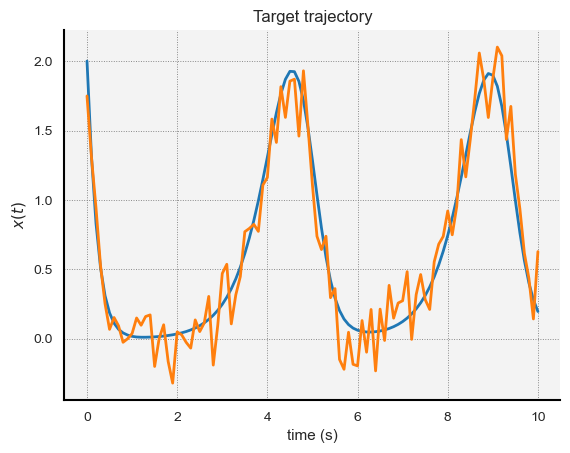

In [15]:
"""
# Exponential 
from    Model   import  Exponential         as F_Model;
from    X0      import  Affine              as X0_Model;

# Set up the parameters and tau value for the target trajectory.
F_Target        = F_Model(theta_0 = -2.0, theta_1 = -2.0);
a_Target        = torch.Tensor([1.5]);
b_Target        = torch.Tensor([4.0]);
X0_Target       = X0_Model(a = a_Target, b = b_Target);
tau_Target      = torch.tensor(1.0);
N_tau           = 10;
T_Target        = torch.tensor(10.0);
"""

# Logistic 
from    Model   import  Logistic              as F_Model;
from    X0      import  Periodic              as X0_Model;

# Set up the parameters and tau value for the target trajectory.
F_Target        = F_Model(theta_0 = 2.0, theta_1 = 1.5);
A_Target        = torch.Tensor([-0.5]);
w_Target        = torch.Tensor([3.0]);
b_Target        = torch.Tensor([2.0]);
X0_Target       = X0_Model(A = A_Target, w = w_Target, b = b_Target);
tau_Target      = torch.tensor(1.0);
N_tau           = 10;
T_Target        = torch.tensor(10.0);

"""
# ESNO
from    Model   import  ENSO                as F_Model;
from    X0      import  Periodic            as X0_Model;

# Set up the parameters and tau value for the target trajectory.
F_Target        = F_Model(theta_0 = 1.0, theta_1 = 1.0, theta_2 = 0.75);
A_Target        = torch.Tensor([-0.25]);
w_Target        = torch.Tensor([1.0]);
b_Target        = torch.Tensor([1.5])
X0_Target       = X0_Model(A = A_Target, w = w_Target, b = b_Target);
tau_Target      = torch.tensor(5.0);
N_tau           = 50;
T_Target        = torch.tensor(10.0);
"""

"""
# Cheyne 
from    Model   import  Cheyne              as F_Model;
from    X0      import  Affine              as X0_Model;

# Set up the parameters and tau value for the target trajectory.
F_Target        = F_Model(p = 1.0, V0 = 7.0, a = 2.0, m = 8);
a_Target        = torch.Tensor([-5.0]);
b_Target        = torch.Tensor([2]);
X0_Target       = X0_Model(a = a_Target, b = b_Target);
tau_Target      = torch.tensor(0.25);
N_tau           = 10;
T_Target        = torch.tensor(3.0);
"""

"""
# HIV
from    Model   import  HIV                 as F_Model;
from    X0      import  Periodic              as X0_Model;

# Set up the parameters and tau value for the target trajectory.
F_Target        = F_Model(  k   = .00343, 
                            m   = 5.0, 
                            d   = 0.05, 
                            c   = 2.0,
                            T0  = 1000.0, 
                            np  = 0.43, 
                            N   = 48.0);
A_Target        = torch.Tensor([2.5,    2.0,    0.0]);
w_Target        = torch.Tensor([1.0,    5.0,    0.0]);
b_Target        = torch.Tensor([10,     8.0,   0.0]);
X0_Target       = X0_Model(A = A_Target, w =w_Target, b = b_Target);
tau_Target      = torch.tensor(1.0);
N_tau           = 10;
T_Target        = torch.tensor(10.0);
"""

# Get the target trajectory!
x_True, t_Target    = DDE_Solver(F = F_Target, X0 = X0_Target, tau = tau_Target, T = T_Target, N_tau = N_tau);

# Add some noise!
x_Target            = Add_Noise(x_True, l = 0.3);

# Finally, lets plot the target trajectory.
seaborn.lineplot(x = t_Target, y = x_True[:,    0].reshape(-1).detach().numpy());
seaborn.lineplot(x = t_Target, y = x_Target[:,  0].reshape(-1).detach().numpy());
seaborn.despine();
plt.xlabel("time (s)");
plt.ylabel(r"$x(t)$");
plt.title("Target trajectory");

### Train the model

In [41]:
"""
# Exponential 

# Pick a starting position, tau, and x0
tau     = (tau_Target*2.0).clone().detach().requires_grad_(True);
a       = (a_Target*1.5).clone().detach().requires_grad_(True);
b       = (b_Target*0.7).clone().detach().requires_grad_(True);
T       = torch.clone(T_Target).requires_grad_(False);

# Set up a NDDE object. We will try to train the enclosed model to match the one we used to generate the above plot.
F_MODEL     = F_Model(theta_0 = -1.5, theta_1 = -2.5);
X0_MODEL    = X0_Model(a, b);

Param_List  : List  = [tau] + list(F_MODEL.parameters()) + list(X0_MODEL.parameters());

"""

# Logistic

# Pick a starting position, tau, and x0
tau     = (tau_Target*0.5).clone().detach().requires_grad_(True);
A       = (A_Target*0.5).clone().detach().requires_grad_(True);
w       = (w_Target*2.0).clone().detach().requires_grad_(True);
b       = (b_Target*1.3).clone().detach().requires_grad_(True);
T       = torch.clone(T_Target).requires_grad_(False);

# Set up a NDDE object. We will try to train the enclosed model to match the one we used to generate the above plot.
F_MODEL     = F_Model(theta_0 = 1.0, theta_1 = 1.0);
X0_MODEL    = X0_Model(A, w, b);

Param_List  : List  = [tau] + list(F_MODEL.parameters()) + list(X0_MODEL.parameters());

"""
# ENSO

# Pick a starting position, tau, and x0
tau     = (tau_Target*1.2).clone().detach().requires_grad_(True);
A       = (A_Target*1.2).clone().detach().requires_grad_(True);
w       = (w_Target*0.8).clone().detach().requires_grad_(True);
b       = (b_Target*1.3).clone().detach().requires_grad_(True);
T       = torch.clone(T_Target).requires_grad_(False);

# Set up a NDDE object. We will try to train the enclosed model to match the one we used to generate the above plot.
F_MODEL     = F_Model(a = 1.5, b = 0.8, c = 1.2);
X0_MODEL    = X0_Model(A, w, b);

Param_List  : List  = [tau] + list(F_MODEL.parameters()) + list(X0_MODEL.parameters());
"""

"""
# Cheyne

# Pick a starting position, tau, and x0
tau     = (tau_Target*2.0).clone().detach().requires_grad_(True);
a       = (torch.zeros_like(a_Target)).clone().detach().requires_grad_(True);
b       = (x_Target[0, :]).clone().detach().requires_grad_(True);
T       = torch.clone(T_Target).requires_grad_(False);

# Set up a NDDE object. We will try to train the enclosed model to match the one we used to generate the above plot.
F_MODEL     = F_Model(p = 2.0, V0 = 12.0, a = 1.5, m = 8);
X0_MODEL    = X0_Model(a, b);

Param_List  : List  = [tau] + list(F_MODEL.parameters()) + list(X0_MODEL.parameters());
"""


"""
# Neural 
from    Model           import      Neural;

# Pick a starting position, tau, and x0
tau     = (tau_Target*1.5).clone().detach().requires_grad_(True);
a       = (a_Target*1.0).clone().detach().requires_grad_(True);
b       = (b_Target*1.0).clone().detach().requires_grad_(True);
T       = torch.clone(T_Target).requires_grad_(False);

# Set up a NDDE object. We will try to train the enclosed model to match the one we used to generate the above plot.
F_MODEL     = Neural(Widths = [4, 5, 5, 1]);
X0_MODEL    = X0_Model(a, b);

Param_List  : List  = [tau] + list(X0_MODEL.parameters());
"""

"""
# HIV 

# Pick a starting position, tau, and x0
tau     = (tau_Target*0.5).clone().detach().requires_grad_(True);
A       = (A_Target*1.2).clone().detach().requires_grad_(True);
w       = (w_Target*2.0).clone().detach().requires_grad_(True);
b       = (b_Target*0.8).clone().detach().requires_grad_(True);
T       = torch.clone(T_Target).requires_grad_(False);

# Set up a NDDE object. We will try to train the enclosed model to match the one we used to generate the above plot.
F_MODEL     = F_Model(  k   = .00343, 
                        m   = 5.0, 
                        d   = 0.05, 
                        c   = 2.0,
                        T0  = 1000.0, 
                        np  = 0.43, 
                        N   = 48.0);
X0_MODEL    = X0_Model(A, w, b);

Param_List  : List  = [tau] + list(F_MODEL.parameters()) + list(X0_MODEL.parameters());
"""



# Settings for training
N_Epochs            : int   = 1000;
Learning_Rate       : float = 0.005;
Loss_Threshold      : float = 0.01;             # We stop training if the loss goes below this level.

# Set up the DDE Module
DDE_Module  = NDDE(F = F_MODEL, X0 = X0_MODEL);


# Select the optimizer, number of epochs.
Optimizer           = torch.optim.Adam(Param_List, lr = Learning_Rate);
Scheduler           = torch.optim.lr_scheduler.CosineAnnealingLR(
                                            optimizer   = Optimizer, 
                                            T_max       = N_Epochs,
                                            eta_min     = Learning_Rate/10.);

# Train!
t_Predict, x_Predict  = Train(  DDE_Module          = DDE_Module, 
                                tau                 = tau,
                                N_tau               = N_tau, 
                                T                   = T, 
                                N_Epochs            = N_Epochs, 
                                x_Target            = x_Target, 
                                t_Target            = t_Target, 
                                l                   = l,
                                G                   = G,
                                Loss_Threshold      = Loss_Threshold, 
                                Optimizer           = Optimizer, 
                                Scheduler           = Scheduler,
                                Writer              = TB_Writer);

  10:   Loss = 5.01944  | tau = 0.45874  | grad tau =   0.02188
  20:   Loss = 5.00257  | tau = 0.43752  | grad tau =  -0.12522
  30:   Loss = 4.94883  | tau = 0.43796  | grad tau =  -0.11683
  40:   Loss = 4.89017  | tau = 0.45393  | grad tau =  -0.12337
  50:   Loss = 4.85322  | tau = 0.48342  | grad tau =  -0.17338
  60:   Loss = 4.81129  | tau = 0.52711  | grad tau =  -0.27620
  70:   Loss = 4.76053  | tau = 0.58805  | grad tau =  -0.41420
  80:   Loss = 4.68936  | tau = 0.66471  | grad tau =  -0.64659
  90:   Loss = 4.54999  | tau = 0.75348  | grad tau =  -1.15226
 100:   Loss = 4.39345  | tau = 0.84356  | grad tau =  -1.70747
 110:   Loss = 4.55048  | tau = 0.94207  | grad tau =  -2.37284
 120:   Loss = 6.62307  | tau = 0.97143  | grad tau =   3.56678
 130:   Loss = 6.20795  | tau = 0.90531  | grad tau =   2.18034
 140:   Loss = 5.91369  | tau = 0.83742  | grad tau =   1.29111
 150:   Loss = 5.75713  | tau = 0.78593  | grad tau =   0.86439
 160:   Loss = 5.67139  | tau = 0.74841 

ValueError: `y` must contain only finite values.

### Plot the Predicted vs Target vs True trajectories

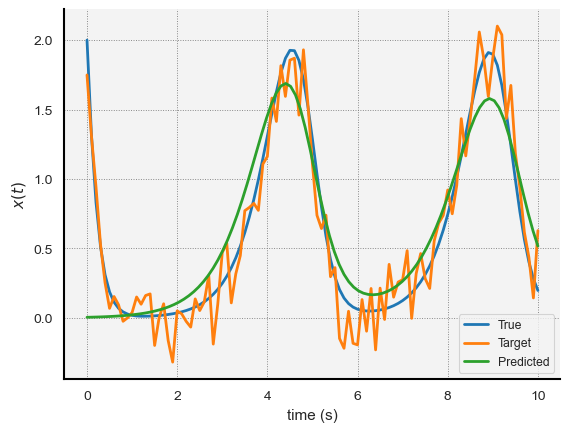

In [36]:
####################################################################################################
# Plot target, final trajectory

plt.figure(1);
plt.plot(t_Target,  x_True[:, 0].detach().numpy(),      label = "True");
plt.plot(t_Target,  x_Target[:,  0].detach().numpy(),   label = "Target");
plt.plot(t_Predict, x_Predict[:, 0].detach().numpy(),   label = "discovered");
seaborn.despine();
plt.xlabel("time (s)");
plt.ylabel(r"$x(t)$");
plt.legend(["True", "Target","Predicted"]);

### Plot the loss as a function of $\tau$

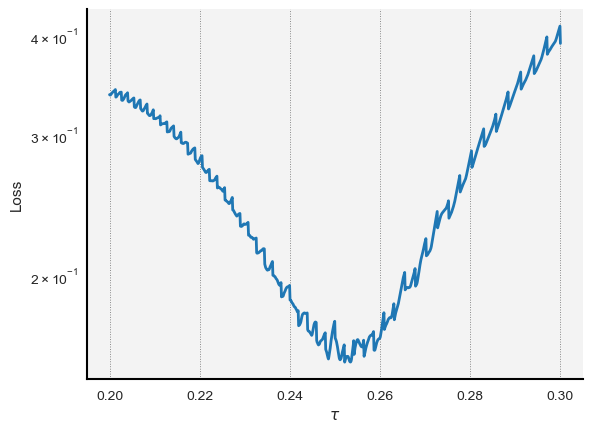

In [7]:
####################################################################################################
# Plot loss as a function of tau

# Set up a grid of tau values. We will find the loss at each one.
N_Steps : int   = 1000;
grid_tau        = torch.linspace(0.2, 0.3, steps = N_Steps, requires_grad = True);
Loss_tau        = torch.zeros(N_Steps);

for i in range(N_Steps):
    # Find predictions for ith tau value.
    Predictions_i, t_Values_i = DDE_Solver(F_Target, X0_Target, grid_tau[i], T, N_tau = N_tau);

    # Interpolate true solution on the time step grid for this solution.
    N_i                 : int           = Predictions_i.shape[0];
    x_Interp                            = interpolate.CubicSpline(t_Target.detach().numpy(), x_Target.detach().numpy());
    Targets_i           : torch.Tensor  = torch.from_numpy(x_Interp(t_Values_i)).to(dtype = torch.float32);
    
    # Compute loss
    Loss_tau[i] = Integral_Loss(Predictions_i, Targets_i, t_Values_i, l) + G(Targets_i[-1, :], Predictions_i[-1, :]);

# Plot!
plt.figure(2);
seaborn.lineplot(x = grid_tau.detach().numpy(), y = Loss_tau.detach().numpy());
seaborn.despine();
plt.xlabel(r"$\tau$");
plt.ylabel("Loss");
plt.yscale("log");

### Serialize the model

In [ ]:
# First, find a save name
Base_Name   : str   = "Neural";
Save_Dir    : str   = os.path.join(os.curdir, "Saves");
Counter     : int   = 0;

Save_Path   : str   = os.path.join(Save_Dir, Base_Name + "_" + str(Counter));
while(os.path.isfile(Save_Path)):
    Counter    += 1;
    Save_Path   = os.path.join(Save_Dir, Base_Name + "_" + str(Counter));

# Now, serialize the model. 
F_State_Dict    : dict  = F_MODEL.state_dict();
X0_State_Dict   : dict  = X0_MODEL.state_dict();
Save_Dict       : dict  = {"F" : F_State_Dict, "Widths" : Widths, "X0" : X0_State_Dict, "tau" : tau};
torch.save(Save_Dict, Save_Path);